In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import utils
import forward_model
import globals
import gradient_descent
import least_squares
import section_search
import coordinate_descent
import initialization

import torch

cuda
tensor([[1.3899, 1.3899, 1.3900,  ..., 1.8624, 1.8626, 1.8627],
        [1.3895, 1.3896, 1.3894,  ..., 1.8628, 1.8632, 1.8632],
        [1.3883, 1.3890, 1.3888,  ..., 1.8648, 1.8658, 1.8663],
        ...,
        [0.9879, 0.9882, 0.9884,  ..., 1.3799, 1.3799, 1.3799],
        [1.0255, 1.0262, 1.0269,  ..., 1.3797, 1.3797, 1.3797],
        [1.0256, 1.0262, 1.0269,  ..., 1.3797, 1.3797, 1.3797]])


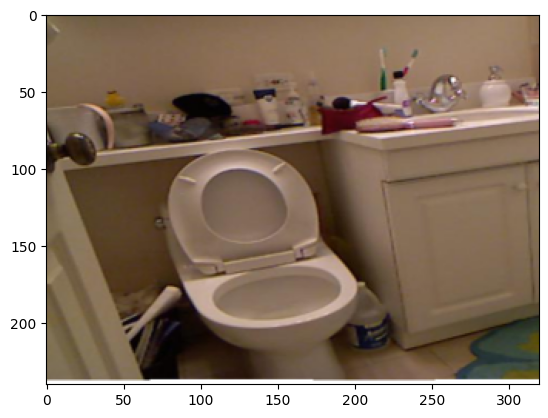

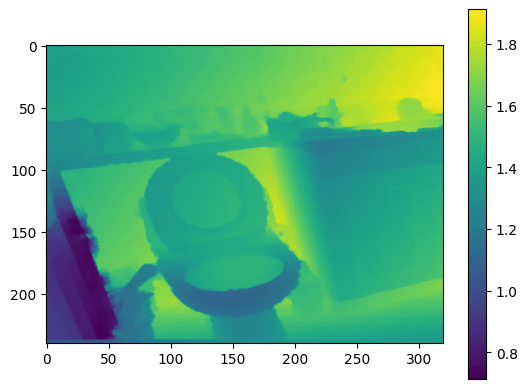

In [2]:
globals.init_NYUv2()

# EXPERIMENT_NAME = 'coord-descent-bracket-search'
# experiment_folder = utils.create_experiment_folder(EXPERIMENT_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# load data 
# gt_aif, gt_dpt = utils.load_single_sample(sample='0001', set='test', fs=5, res='half')
gt_aif, gt_dpt, gt_defocus_stack = utils.load_sample_image(fs=5, res='half')
print(gt_dpt)

plt.imshow(gt_aif)
plt.show()

plt.imshow(gt_dpt)
plt.colorbar()
plt.show()

width, height = gt_dpt.shape

# max_kernel_size = utils.kernel_size_heuristic(width, height)
# print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(7)

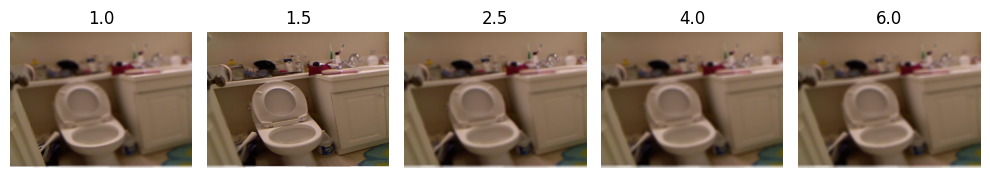

In [3]:
# ground truth defocus stack
utils.plot_single_stack(gt_defocus_stack, globals.Df)


In [5]:

r = forward_model.computer(gt_dpt, globals.Df)
# r = r.unsqueeze(-1).unsqueeze(-1)
print(r[237,110])

width, height, fs = r.squeeze().shape

y, x = torch.meshgrid(
    torch.arange(width),
    torch.arange(height),
    indexing='ij')


tensor([2.8311, 1.7077, 5.2275, 7.1657, 8.2298])


In [ ]:

print(r.shape, y.shape, x.shape)

lim = globals.MAX_KERNEL_SIZE // 2

kernel_sum = torch.zeros((fs, width, height))
defocus_stack = torch.zeros((fs, width, height, 3))
for n in range(fs):
    defocus_stack[n] = aif.clone()

for n in range(fs):
    sigma = r[:,:,n].squeeze()
    mask1 = sigma > 1
    kernel_sum[n][sigma <= 1] = 1.
    for i in range(globals.MAX_KERNEL_SIZE):
        mask2 = ((y + i - mid) >= 0) & ((y + i - mid) < height)
        for j in range(globals.MAX_KERNEL_SIZE):
            mask3 = ((x + j - mid) >= 0) & ((x + j - mid) < width)
            mask = (mask1 & mask2 & mask3)
            sigma_masked = sigma[mask]
            g = (1.0 / (sigma_masked * sigma_masked)) * torch.exp(-2.0 * ((i-mid) * (i-mid) + (j-mid) * (j-mid)) / (sigma_masked * sigma_masked))
            kernel_sum[n,:,:][mask] += g
            defocus_stack[n,:,:,0][mask] += g * aif[:,:,0][mask]
            defocus_stack[n,:,:,1][mask] += g * aif[:,:,1][mask]
            defocus_stack[n,:,:,2][mask] += g * aif[:,:,2][mask]

for n in range(fs):
    defocus_stack = defocus_stack / kernel_sum.unsqueeze(-1)

return defocus_stack